In [44]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import grad

Absorption cross-section: 7.786474865982591e-18


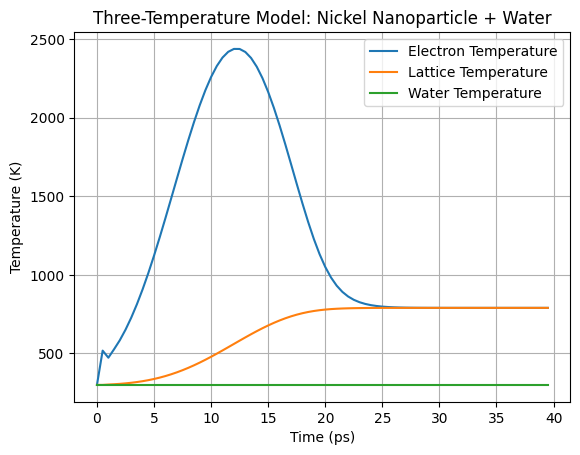

In [45]:

# Constants (SI units)
K_B = 1.380649e-23  # Boltzmann constant, J/K
C_e_coeff = 100  # Rough estimation for the electronic heat capacity coefficient, J/(m^3*K^2) Ce(Te) ? Pas une fonciton de la tempréature ?
C_i = 4.5e6  # Lattice heat capacity, J/(m^3*K)
C_w = 4.184e6  # Heat capacity of water, J/(m^3*K)
gamma = 1e17  # Electron-phonon coupling constant, W/(m^3*K) G(Te) ?
h = 1e5  # Heat transfer coefficient to water, W/(m^2*K)

T_m = 300  # Initial water temperature, K (also initial NP temp)
radius = 5e-9  # Nanoparticle radius, m
area = np.pi * (radius**2)  # Cross-sectional area, m^2
volume = (4/3) * np.pi * (radius**3)  # Nanoparticle volume, m^3
water_volume = (4/3) * np.pi * ((radius * 2)**3) - volume
# Define size of water volume around NanoParticle for modelling heat dissipation.

# Laser parameters
fluence = 300  # J/m^2 (30 mJ/cm^2)
tau = 1e-11  # Pulse duration, s (100 fs)
wavelength = 400e-9  # Laser wavelength, m

# Optical Properties (Nickel) - Change for other materials as needed
n = 2.3  # Refractive index
k = 3.5  # Extinction coefficient

epsilon = (n + 1j * k)**2  # Complex dielectric function
epsilon_m = 1.77  # Water dielectric function

sigma_abs = ((8 * np.pi**2 * radius**3) / wavelength) * np.imag((epsilon - epsilon_m) / (epsilon + 2 * epsilon_m))

print("Absorption cross-section:", sigma_abs)

# Time axis setup
time_step = tau / 20  # Smaller time steps for more accurate results
time = np.arange(0, 40e-12, time_step)  # Time from 0 to 40 ps

# Gaussian laser pulse function (Corrected for peak at t=0)
def gaussian_pulse(t):
    return (fluence / (tau * np.sqrt(np.pi / np.log(2)))) * np.exp((-4 * np.log(2) * (t - tau)**2) / tau**2) # Fixed time component

# Time-dependent laser source term Q (Power density)
intensity = gaussian_pulse(time)

Q = (sigma_abs * intensity) / volume  # Volumetric heat source, W/m^3

# Initialize temperature arrays
Te = np.zeros(len(time))
Ti = np.zeros(len(time))
Tw = np.zeros(len(time))

Te[0] = T_m  # Initial temperatures equal to surrounding water
Ti[0] = T_m
Tw[0] = T_m

#Verlet Algorithm (Explicit):
for i in range(0, len(time) - 1):
    C_e = C_e_coeff * Te[i]  # Update electron heat capacity based on temperature
    dt = time_step

    # Calculate new Te, Ti and Tw
    Te[i + 1] = Te[i] + (dt / C_e) * (-gamma * (Te[i] - Ti[i]) + Q[i] - h * (Te[i] - Tw[i]))
    Ti[i + 1] = Ti[i] + (dt / C_i) * (gamma * (Te[i] - Ti[i]) - h * (Ti[i] - Tw[i]))
    Tw[i + 1] = Tw[i] + (dt / C_w) * (h * (Ti[i] - Tw[i]) * volume / water_volume)

    # Ensure temperatures don't go below 0
    Te[i + 1] = max(Te[i + 1], 0)
    Ti[i + 1] = max(Ti[i + 1], 0)
    Tw[i + 1] = max(Tw[i + 1], 0)

# Plotting the results
plt.plot(time / (1e-12), Te, label="Electron Temperature")
plt.plot(time / (1e-12), Ti, label="Lattice Temperature")
plt.plot(time / (1e-12), Tw, label="Water Temperature")

plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Three-Temperature Model: Nickel Nanoparticle + Water")
plt.legend()
plt.grid(True)
plt.show()

Fonction pour générer les données 

In [46]:
# Constants (SI units)
K_B = 1.380649e-23  # Boltzmann constant, J/K
C_e_coeff = 100     # J/(m^3*K^2)  -> Ce(Te) = C_e_coeff * Te
C_i = 4.5e6         # Lattice heat capacity, J/(m^3*K)
C_w = 4.184e6       # Heat capacity of water, J/(m^3*K)
gamma = 1e17        # Electron-phonon coupling constant, W/(m^3*K)
h = 1e5             # Heat transfer coefficient to water, W/(m^2*K)

T_m = 300           # Initial temperature, K
radius = 5e-9
area = np.pi * (radius**2)
volume = (4/3) * np.pi * (radius**3)
water_volume = (4/3) * np.pi * ((radius * 2)**3) - volume

def generate_data(
    fluence=300,          # J/m^2  (30 mJ/cm^2) , laser fluence
    tau=1e-11,            # s  ,pulse duration (100 fs)
    wavelength=400e-9,    # m  , laser wavelength
    n=2.3,                # refractive index (Nickel, approx)
    k=3.5,                # extinction coefficient
    t_end=40e-12,         # s, simulate up to 40 ps
    steps_per_tau=20      # time resolution: dt = tau / steps_per_tau
):
    # optical props
    epsilon = (n + 1j * k)**2
    epsilon_m = 1.77  # water dielectric
    sigma_abs = ((8 * np.pi**2 * radius**3) / wavelength) * np.imag((epsilon - epsilon_m) / (epsilon + 2 * epsilon_m))

    # time axis
    time_step = tau / steps_per_tau
    time = np.arange(0, t_end, time_step)

    # laser pulse (Gaussian centered around t = tau)
    def gaussian_pulse(t):
        return (fluence / (tau * np.sqrt(np.pi / np.log(2)))) * np.exp((-4 * np.log(2) * (t - tau)**2) / tau**2)

    intensity = gaussian_pulse(time)
    Q = (sigma_abs * intensity) / volume  # W/m^3

    # init temps
    Te = np.zeros(len(time)); Ti = np.zeros(len(time)); Tw = np.zeros(len(time))
    Te[0] = T_m; Ti[0] = T_m; Tw[0] = T_m

    # explicit update
    for i in range(0, len(time) - 1):
        C_e = C_e_coeff * Te[i]
        dt = time_step

        Te[i + 1] = Te[i] + (dt / C_e) * (-gamma * (Te[i] - Ti[i]) + Q[i] - h * (Te[i] - Tw[i]))
        Ti[i + 1] = Ti[i] + (dt / C_i) * (gamma * (Te[i] - Ti[i]) - h * (Ti[i] - Tw[i]))
        Tw[i + 1] = Tw[i] + (dt / C_w) * (h * (Ti[i] - Tw[i]) * volume / water_volume)

        # clamp to non-negative
        Te[i + 1] = max(Te[i + 1], 0.0)
        Ti[i + 1] = max(Ti[i + 1], 0.0)
        Tw[i + 1] = max(Tw[i + 1], 0.0)

    return time, Te, Ti, Tw, sigma_abs


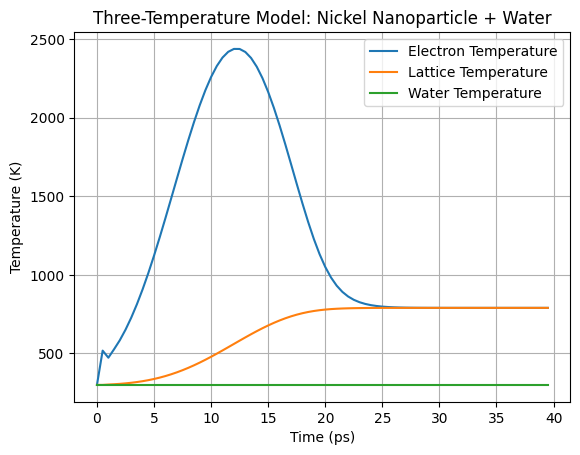

In [47]:
time, Te, Ti, Tw, sigma_abs = generate_data(fluence=300,tau=1e-11,wavelength=400e-9)
# Plotting the results
plt.plot(time / (1e-12), Te, label="Electron Temperature")
plt.plot(time / (1e-12), Ti, label="Lattice Temperature")
plt.plot(time / (1e-12), Tw, label="Water Temperature")

plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Three-Temperature Model: Nickel Nanoparticle + Water")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
data = pd.DataFrame({
    "time_s": time,
    "T_e_K": Te,
    "T_l_K": Ti,
    "T_w_K": Tw,
})
data.head(80)
# data.describe()

,time_s,T_e_K,T_l_K,T_w_K
0,0.000000e+00,300.000000,300.000000,300.0
1,5.000000e-13,518.288109,300.000000,300.0
2,1.000000e-12,473.272481,302.425423,300.0
3,1.500000e-12,527.104327,304.323724,300.0
4,2.000000e-12,583.941867,306.799064,300.0
...,...,...,...,...
75,3.750000e-11,790.311555,790.311547,300.0
76,3.800000e-11,790.311551,790.311547,300.0
77,3.850000e-11,790.311549,790.311547,300.0
78,3.900000e-11,790.311548,790.311547,300.0


In [49]:
def log(msg): 
    from datetime import datetime
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

In [50]:
X = data[["time_s"]].values.astype(np.float32)
y = data[["T_e_K", "T_l_K", "T_w_K"]].values.astype(np.float32)

N = len(X)   # total number of samples
print(f"Total samples: {N}")
n_train = int(0.70 * N)
n_val   = int(0.15 * N)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

# print(y_val)
# print('voici',y_test)

Total samples: 80


In [51]:
from sklearn.preprocessing import StandardScaler
# normalise t ∈ [0,1] selon train
t_max = float(X_train.max())
X_train_s = X_train / t_max
X_val_s   = X_val   / t_max
X_test_s  = X_test  / t_max

# standardise les 3 sorties (fit sur train seulement)
y_scaler = StandardScaler().fit(y_train)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

In [52]:
# === Datasets et DataLoaders ===
class TimeTempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = TimeTempDataset(X_train_s, y_train_s)
val_ds   = TimeTempDataset(X_val_s,   y_val_s)
test_ds  = TimeTempDataset(X_test_s,  y_test_s)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

print(train_loader)

In [53]:
# Reproductibilité - Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device (GPU/CPU) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Usingggg device: {device}")

 Usingggg device: cpu


In [54]:
# === Modèle MLP ===
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden=(64,64), out_dim=3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP().to(device)
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
log(f"MLP initialisé → {params_count} paramètres entraînables sur {device}")

[14:08:13] MLP initialisé → 4483 paramètres entraînables sur cpu


fonction qui calcule la fonction du physical loss 

In [55]:
def grad(outputs, inputs):
    """Partial derivative d(outputs)/d(inputs)."""
    return torch.autograd.grad(
        outputs,
        inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
    )[0]


def physics_loss(model,R_e=1e3,R_l=1e3,R_w=1e3,Tenv=300):
    """
    Physics loss adaptée à un modèle à 3 sorties.
    Chaque sortie suit une ODE que tu peux définir ici.
    """
    # Collocation points
    ts = torch.linspace(0, 1000, steps=1000).view(-1,1).requires_grad_(True)

    # Passage dans le réseau
    temps = model(ts)   # shape: (1000, 3)

    T_e = temps[:, 0:1]
    T_l = temps[:, 1:1+1]  # équivalent à temps[:,1:2]
    T_w = temps[:, 2:2+1]

    # Dérivées temporelles
    dT_e = grad(T_e, ts)
    dT_l = grad(T_l, ts)
    dT_w = grad(T_w, ts)

    # ============================
    #   ICI : Définis tes ODEs
    # ============================
    
    # Exemple pour un modèle de refroidissement
    ode_e = dT_e - R_e*(Tenv - T_e)
    ode_l = dT_l - R_l*(Tenv - T_l)
    ode_w = dT_w - R_w*(Tenv - T_w)

    # Total physics loss
    loss = (
        torch.mean(ode_e**2) +
        torch.mean(ode_l**2) +
        torch.mean(ode_w**2)
    )

    return loss


Ici , c'est la tâche 1 sans PINN

In [56]:
# === Entraînement ===
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS, PATIENCE = 50, 30

best_val = np.inf
wait = 0
best_state = None
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS + 1):
    # --- phase train ---
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()    # backpropagation
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    # --- phase val ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    improved = val_loss < best_val - 1e-8
    if improved:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1

    if epoch % 20 == 0 or epoch == 1 or improved:
        log(f"Epoch {epoch:03d} | Train={train_loss:.6f} | Val={val_loss:.6f} | Best={best_val:.6f} | Wait={wait}")
    if wait >= PATIENCE:
        log(f"Early stopping at epoch {epoch}")
        break

model.load_state_dict(best_state)
log("Best model restored.")

[14:08:13] Epoch 001 | Train=0.703433 | Val=0.784713 | Best=0.784713 | Wait=0
[14:08:13] Epoch 002 | Train=0.688800 | Val=0.740913 | Best=0.740913 | Wait=0
[14:08:13] Epoch 003 | Train=0.675685 | Val=0.700511 | Best=0.700511 | Wait=0
[14:08:13] Epoch 004 | Train=0.663837 | Val=0.662279 | Best=0.662279 | Wait=0
[14:08:13] Epoch 005 | Train=0.652985 | Val=0.625993 | Best=0.625993 | Wait=0
[14:08:13] Epoch 006 | Train=0.643089 | Val=0.591857 | Best=0.591857 | Wait=0
[14:08:13] Epoch 007 | Train=0.634081 | Val=0.561091 | Best=0.561091 | Wait=0
[14:08:13] Epoch 008 | Train=0.625966 | Val=0.532542 | Best=0.532542 | Wait=0
[14:08:13] Epoch 009 | Train=0.618659 | Val=0.505771 | Best=0.505771 | Wait=0
[14:08:13] Epoch 010 | Train=0.611865 | Val=0.480885 | Best=0.480885 | Wait=0
[14:08:13] Epoch 011 | Train=0.605479 | Val=0.457690 | Best=0.457690 | Wait=0
[14:08:13] Epoch 012 | Train=0.599539 | Val=0.435988 | Best=0.435988 | Wait=0
[14:08:13] Epoch 013 | Train=0.593738 | Val=0.415604 | Best=0.41

Ici , quand il y a PINN

In [61]:
lambda_phys = 1e-10  # poids de la physical loss
EPOCHS, PATIENCE = 50, 30

for epoch in range(1, EPOCHS + 1):
    # --- phase train ---
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        # prédiction data
        pred = model(xb)

        # loss data classique
        loss_data = criterion(pred, yb)

        # loss physique (PINN)
        loss_phys = physics_loss(model)

        # loss totale
        loss = loss_data + lambda_phys * loss_phys

        # backprop
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * len(xb)

    train_loss /= len(train_loader.dataset)

    # --- phase val ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)   # PAS de physics loss en validation
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    # improved = val_loss < best_val - 1e-8
    # if improved:
    #     best_val = val_loss
    #     best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
    #     wait = 0
    # else:
    #     wait += 1

    #if epoch % 1 == 0 or epoch == 1 or improved:
    log(f"Epoch {epoch:03d} | Train={train_loss:.6f} | Val={val_loss:.6f} | Best={best_val:.6f} | Wait={wait}")

    # if wait >= PATIENCE:
    #     log(f"Early stopping at epoch {epoch}")
    #     break

model.load_state_dict(best_state)
log("Best model restored.")


[14:20:26] Epoch 001 | Train=67.877167 | Val=0.086098 | Best=0.082888 | Wait=33
[14:20:26] Epoch 002 | Train=67.252380 | Val=0.089112 | Best=0.082888 | Wait=33
[14:20:26] Epoch 003 | Train=66.710846 | Val=0.091999 | Best=0.082888 | Wait=33
[14:20:26] Epoch 004 | Train=66.304039 | Val=0.094742 | Best=0.082888 | Wait=33
[14:20:26] Epoch 005 | Train=65.940620 | Val=0.097277 | Best=0.082888 | Wait=33
[14:20:26] Epoch 006 | Train=65.615608 | Val=0.099618 | Best=0.082888 | Wait=33
[14:20:26] Epoch 007 | Train=65.324684 | Val=0.101796 | Best=0.082888 | Wait=33
[14:20:26] Epoch 008 | Train=65.064034 | Val=0.103814 | Best=0.082888 | Wait=33
[14:20:26] Epoch 009 | Train=64.830307 | Val=0.105672 | Best=0.082888 | Wait=33
[14:20:26] Epoch 010 | Train=64.620552 | Val=0.107381 | Best=0.082888 | Wait=33
[14:20:26] Epoch 011 | Train=64.432175 | Val=0.108942 | Best=0.082888 | Wait=33
[14:20:26] Epoch 012 | Train=64.262871 | Val=0.110364 | Best=0.082888 | Wait=33
[14:20:26] Epoch 013 | Train=64.110626 |